In [5]:
import numpy as np
from sus.protocol_designer import System, Protocol, Potential, Compound_Protocol
from sus.protocol_designer.protocol import sequential_protocol
from IPython import display
from IPython.display import HTML
from quick_sim import setup_sim
from edward_tools.coupled_fq_potential import coupled_flux_qubit_pot, coupled_flux_qubit_force, coupled_fq_pot
import edward_tools.fq_runner as fq_runner
from edward_tools.visualization import animate_sim_flux_qubit

import kyle_tools as kt
import matplotlib.pyplot as plt

import importlib, os, hashlib, json
from edward_tools import coupled_fq_protocol_library, cfq_runner
from PARAMETER_INPUT import *
from PARAMETER_INPUT import _lambda, _theta, _eta
from ControlParameter import *

from edward_tools import coupled_fq_protocol_library
import edward_tools.cfq_batch_sweep as cfq_batch_sweep
%load_ext jupyternotify

coupled_fq_protocol_library = importlib.reload(coupled_fq_protocol_library)
create_system = coupled_fq_protocol_library.create_system
get_potential_shot_at_different_t = coupled_fq_protocol_library.get_potential_shot_at_different_t
get_potential_shot_at_different_t_1D = coupled_fq_protocol_library.get_potential_shot_at_different_t_1D
create_simple_protocol_parameter_dict = coupled_fq_protocol_library.create_simple_protocol_parameter_dict
create_system_from_storage_and_computation_protocol = coupled_fq_protocol_library.create_system_from_storage_and_computation_protocol
coupled_fq_runner = importlib.reload(cfq_runner)
coupled_fq_protocol_library = importlib.reload(coupled_fq_protocol_library)
create_system = coupled_fq_protocol_library.create_system

get_potential_along_a_1D_cutline = coupled_fq_protocol_library.get_potential_along_a_1D_cutline
plotCutlines = coupled_fq_protocol_library.plotCutlines


<IPython.core.display.Javascript object>

In [49]:
"""
# step 0: modify parameters
- All the parameters are stored in a separate file PARAMETER_INPUT
- You can override some of the parameters here.
"""
N = 50_00
params['N'] = N
params['dt'] = dt/10

In [50]:
"""
# step 1: Define potential
"""
coupled_fq_default_param = [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, x_c0]
[phi_1_bound, phi_2_bound, phi_1dc_bound, phi_2dc_bound] = np.array([4, 4, 4, 4])/time_scale_factor

coupled_fq_domain = [[-phi_1_bound, -phi_2_bound, -phi_1dc_bound, -phi_2dc_bound], \
                     [phi_1_bound, phi_2_bound, phi_1dc_bound, phi_2dc_bound]]

coupled_fq_pot = Potential(coupled_flux_qubit_pot, coupled_flux_qubit_force, 14, 4,\
                           default_params = coupled_fq_default_param,  relevant_domain = coupled_fq_domain)

In [51]:
params

{'N': 5000,
 'dt': 0.001,
 'lambda': 1,
 'beta': 1,
 'sim_params': [array([0.00269542, 0.00269542, 0.00269542, 0.00269542]),
  array([1., 4., 1., 4.]),
  array([0.01310394, 0.02620788, 0.01310394, 0.02620788])],
 'target_work': None,
 'comment': ''}

In [52]:
"""
# step 2: Define initial condition and protocol
"""
manual_domain=[np.array([-5, -5]), np.array([5, 5])]
phi_1_dcx, phi_2_dcx = 0, 0
phi_1_dc, phi_2_dc = phi_1_dcx, phi_2_dcx

In [53]:
# time length
time_length_1 = 80
time_length_2 = 40
time_length_3 = 80
time_length_4 = 80
time_length_5 = 60
time_length_6 = 60

phi_1_dcx_on = 2.8
phi_2_dcx_on = 2.8
M_12_on = -0.5

In [54]:
initial_parameter_dict = {
        "U0_1": U0_1,     "U0_2": U0_2,     "gamma_1": gamma,  "gamma_2": gamma,
        "beta_1": beta_1,   "beta_2": beta_2,   "d_beta_1": d_beta_1 ,   "d_beta_2": d_beta_2,
        "phi_1_x": 0,  "phi_2_x": 0,  "phi_1_dcx": phi_1_dcx_off,  "phi_2_dcx": phi_2_dcx_off,
        "M_12": M_12_off, 'x_c': x_c
}


protocol_list_options = [
    {"placeholder": ""},
    # forward
    {"duration":time_length_1, "phi_1_dcx": phi_1_dcx_off, "phi_2_dcx": phi_2_dcx_on,  "M_12": M_12_off,  "name":"(1) mix in y direction"},
    {"duration":time_length_2, "phi_1_dcx": phi_1_dcx_off, "phi_2_dcx": phi_2_dcx_on,  "M_12": M_12_on,   "name":"(2) conditional tilt"},
    {"duration":time_length_3, "phi_1_dcx": phi_1_dcx_off, "phi_2_dcx": phi_2_dcx_off, "M_12": M_12_on,   "name":"(3) raise the barrier"},
    {"duration":time_length_4, "phi_1_dcx": phi_1_dcx_off,  "phi_2_dcx": phi_2_dcx_off, "M_12": M_12_off,  "name":"(4) 4 well potential 1st time"}, 
    {"duration":time_length_5, "phi_1_dcx": phi_1_dcx_on,  "phi_2_dcx": phi_2_dcx_off, "M_12": M_12_off,  "name":"(5) mix in x direction"}, 
    {"duration":time_length_6, "phi_1_dcx": phi_1_dcx_off, "phi_2_dcx": phi_2_dcx_off, "M_12": M_12_off,  "name":"(6) 4 well potential"}, 
    
    # reverse
    {"duration":time_length_6, "phi_1_dcx": phi_1_dcx_on,  "phi_2_dcx": phi_2_dcx_off, "M_12": M_12_off,  "name":"(-6) 4 well potential 2nd time"}, 
    {"duration":time_length_5, "phi_1_dcx": phi_1_dcx_off, "phi_2_dcx": phi_2_dcx_off, "M_12": M_12_off,  "name":"(-5) anti-mix in x direction"}, 
    {"duration":time_length_4, "phi_1_dcx": phi_1_dcx_off, "phi_2_dcx": phi_2_dcx_off, "M_12": M_12_on,   "name":"(-4) anti-raise the barrier 1st time"},
    {"duration":time_length_3, "phi_1_dcx": phi_1_dcx_off, "phi_2_dcx": phi_2_dcx_on,  "M_12":  M_12_on,  "name":"(-3) anti-raise the barrier"},
    {"duration":time_length_2, "phi_1_dcx":phi_1_dcx_off,  "phi_2_dcx": phi_2_dcx_on,  "M_12": M_12_off,  "name":"(-2) anit-conditional tilt"},
    {"duration":time_length_1, "phi_1_dcx":phi_1_dcx_off,  "phi_2_dcx": phi_2_dcx_off, "M_12": M_12_off,  "name":"(-1) anti- mix in y direction"}
]

In [55]:
zeroDissipation = False
params['sim_params'] = [_lambda, _theta, _eta]
if zeroDissipation:
    params['sim_params'] = [_lambda * 0, _theta, _eta * 0]



"""
0 -> 1 -> 0     (0, 0, 0), (0, 3, 0), (0, 0, 0)
1 -> 2 -> 1  (0, 3, 0), (0, 3, -0.8), (0, 3, 0)
2 -> 3 -> 2  (0, 3, -0.8), (0, 0, -0.8), (0, 3, -0.8)
3 -> 4 -> 3  (0, 0, -0.8), (0, 0, 0), (0, 0, -0.8)
4 -> 5 -> 4  (0, 0, 0), (3, 0, 0), (0, 0, 0)
5 -> 6 -> 5  (3, 0, 0), (0, 0, 0), (3, 0, 0)
"""
TR_initial_condition = [
    (phi_1_dcx_off, phi_2_dcx_off, M_12_off), 
    (phi_1_dcx_off, phi_2_dcx_on,  M_12_off), 
    (phi_1_dcx_off, phi_2_dcx_on,  M_12_on), 
    (phi_1_dcx_off, phi_2_dcx_off, M_12_on), 
    (phi_1_dcx_off, phi_2_dcx_off, M_12_off), 
    (phi_1_dcx_on,  phi_2_dcx_off, M_12_off)]

protocol_index = 0

# initial_parameter_dict["phi_1_dcx"], initial_parameter_dict["phi_2_dcx"], initial_parameter_dict["M_12"] = TR_initial_condition[protocol_index-1]
initial_parameter_dict["phi_1_dcx"], initial_parameter_dict["phi_2_dcx"], initial_parameter_dict["M_12"] = TR_initial_condition[protocol_index]

rest = {"duration": 30, "name":"rest"}
# protocol_list = [
#     # forward
#     protocol_list_options[protocol_index + 1],
#     # protocol_list_options[1],
#     # protocol_list_options[2],
#     # protocol_list_options[3],
#     # protocol_list_options[4],
#     # protocol_list_options[5],
#     # protocol_list_options[6],    
    
#     # reverse
#     # protocol_list_options[-5],
#     # protocol_list_options[-4],
#     # protocol_list_options[-3],
#     # protocol_list_options[-2],
#     # protocol_list_options[-1]
#     protocol_list_options[-(protocol_index + 1)]
# ]

protocol_list= [
    {"duration": 100, "phi_1_dcx": phi_1_dcx_off, "phi_2_dcx": phi_2_dcx_on,  "M_12": M_12_off,  "name":"(1) mix in y direction"},
    {"duration": 100, "name":"rest"},
    {"duration":40, "phi_1_dcx": phi_1_dcx_off, "phi_2_dcx": phi_2_dcx_on,  "M_12": M_12_on,   "name":"(2) conditional tilt in y"},
    {"duration":40, "phi_1_dcx": phi_1_dcx_off, "phi_2_dcx": phi_2_dcx_off, "M_12": M_12_on,   "name":"(3) raise the barrier"},
    # {"duration":100, "phi_1_dcx": phi_1_dcx_on, "phi_2_dcx": phi_2_dcx_off,  "M_12": M_12_on,   "name":"(4) conditional tilt in x"},
    {"duration":100, "phi_1_dcx": phi_1_dcx_on,  "phi_2_dcx": phi_2_dcx_off, "M_12": M_12_off,  "name":"(5) mix in x direction"}, 
    # rest,
    {"duration":100, "phi_1_dcx": phi_1_dcx_off, "phi_2_dcx": phi_2_dcx_off, "M_12": M_12_off,  "name":"(6) 4 well potential"}, 
    
]   



print(params['sim_params'])
print(initial_parameter_dict["phi_1_dcx"], initial_parameter_dict["phi_2_dcx"], initial_parameter_dict["M_12"])
for x in protocol_list:
    print(x)
# print(protocol_list[0]["phi_1_dcx"], protocol_list[0]["phi_2_dcx"], protocol_list[0]["M_12"], )
# print(protocol_list[1]["phi_1_dcx"], protocol_list[1]["phi_2_dcx"], protocol_list[1]["M_12"], )


[array([0.00269542, 0.00269542, 0.00269542, 0.00269542]), array([1., 4., 1., 4.]), array([0.01310394, 0.02620788, 0.01310394, 0.02620788])]
0 0 0
{'duration': 100, 'phi_1_dcx': 0, 'phi_2_dcx': 2.8, 'M_12': 0, 'name': '(1) mix in y direction'}
{'duration': 100, 'name': 'rest'}
{'duration': 40, 'phi_1_dcx': 0, 'phi_2_dcx': 2.8, 'M_12': -0.5, 'name': '(2) conditional tilt in y'}
{'duration': 40, 'phi_1_dcx': 0, 'phi_2_dcx': 0, 'M_12': -0.5, 'name': '(3) raise the barrier'}
{'duration': 100, 'phi_1_dcx': 2.8, 'phi_2_dcx': 0, 'M_12': -0.5, 'name': '(4) conditional tilt in x'}
{'duration': 100, 'phi_1_dcx': 2.8, 'phi_2_dcx': 0, 'M_12': 0, 'name': '(5) mix in x direction'}
{'duration': 100, 'phi_1_dcx': 0, 'phi_2_dcx': 0, 'M_12': 0, 'name': '(6) 4 well potential'}


In [56]:

"""
# step 3: create the relevant storage protocol and computation protocol
"""
computation_protocol_parameter_dict = coupled_fq_protocol_library.customizedProtocol(initial_parameter_dict, \
                                                                    protocol_list)
storage_protocol, comp_protocol = create_system(computation_protocol_parameter_dict)

In [57]:
"""
# step 4: create the coupled_fq_runner
"""
cfqr = cfq_runner.coupledFluxQubitRunner(potential = coupled_fq_pot, params = params, \
                                                storage_protocol= storage_protocol, \
                                                computation_protocol= comp_protocol)
cfqr.initialize_sim()
cfqr.set_sim_attributes()
init_state_saved = cfqr.init_state
manual_domain=[np.array([-5, -5])/time_scale_factor, np.array([5, 5])/time_scale_factor]

generating new initial_state
using a lower resolution for searching a space in >3 dimensions
new resolution is 50
 found 5000 samples out of 5000
from system: finish the while loop in sampling.
as step value: slice(None, None, None), sampleSize: 5000
slice(None, None, None)
from cfq_runner.py, The as_step is slice(None, None, None) and dt is 0.001
from quick_sim.py
gamma: [0.00269542 0.00269542 0.00269542 0.00269542], theta: [1. 4. 1. 4.] and eta: [0.01310394 0.02620788 0.01310394 0.02620788]
from quick_sim.py: system.protocol.t_i = 0.0, system.protocol.t_f = 580.0
from simulation.py: number of steps: 580000, dt: 0.001


# equilibrium state  analysis

In [42]:
# from IPython.display import clear_output


# """
# 0 -> 1 -> 0     (0, 0, 0), (0, 3, 0), (0, 0, 0)
# 1 -> 2 -> 1  (0, 3, 0), (0, 3, -0.8), (0, 3, 0)
# 2 -> 3 -> 2  (0, 3, -0.8), (0, 0, -0.8), (0, 3, -0.8)
# 3 -> 4 -> 3  (0, 0, -0.8), (0, 0, 0), (0, 0, -0.8)
# 4 -> 5 -> 4  (0, 0, 0), (3, 0, 0), (0, 0, 0)
# 5 -> 6 -> 5  (3, 0, 0), (0, 0, 0), (3, 0, 0)
# """

# initial_parameter_dict["phi_1_dcx"] = phi_1_dcx_off
# initial_parameter_dict["phi_2_dcx"] = 2.5
# initial_parameter_dict["M_12"] = -0.7

# """
# # step 3: create the relevant storage protocol and computation protocol
# """
# computation_protocol_parameter_dict = coupled_fq_protocol_library.customizedProtocol(initial_parameter_dict, \
#                                                                     protocol_list)
# storage_protocol, comp_protocol = create_system(computation_protocol_parameter_dict)

# cfqr = cfq_runner.coupledFluxQubitRunner(potential = coupled_fq_pot, params = params, \
#                                                 storage_protocol= storage_protocol, \
#                                                 computation_protocol= comp_protocol)
# cfqr.initialize_sim()
# cfqr.set_sim_attributes()
# init_state_saved = cfqr.init_state
# clear_output()
# print("finish")

In [43]:
# plt.scatter(init_state_saved[:, 0, 0], init_state_saved[:, 1, 0])
# # fig, ax = plt.subplots(1, 2, figsize = [10, 4])
# # ax[1].scatter(init_state_saved[:, 0, 0], init_state_saved[:, 1, 0])

# real simulation

In [58]:
# step 5: perform simulations

simResult = cfq_batch_sweep.simulateSingleCoupledFluxQubit(params, initial_parameter_dict, protocol_list, \
                                        initial_state = init_state_saved, manual_domain = manual_domain, \
                                        phi_1_dcx = phi_1_dcx,  phi_2_dcx = phi_2_dcx, \
                                        percentage = 1, \
                                        as_step = np.s_[::100])

cfqr = simResult["cfqr"]

print(f"simulation_date = {simResult['simulation_data']['simulation_date']}")
print(f"simulation time = {simResult['simulation_data']['simulation_time']}s")


 initializing...
use old initial_state
as step value: slice(None, None, 100), sampleSize: 5000
slice(None, None, 100)
from cfq_runner.py, The as_step is slice(None, None, None) and dt is 0.001
from quick_sim.py
gamma: [0.00269542 0.00269542 0.00269542 0.00269542], theta: [1. 4. 1. 4.] and eta: [0.01310394 0.02620788 0.01310394 0.02620788]
from quick_sim.py: system.protocol.t_i = 0.0, system.protocol.t_f = 580.0
from simulation.py: number of steps: 580000, dt: 0.001

 running sim...
final_statestep 579999
all_state
work_done

 analyzing output...
For the states, 
(1859.3614110946655,)
simulation_date = 2024-01-05 00:29:18.070882
simulation time = (1859.3614110946655,)s


# animations

In [59]:
# animations
vmin, vmax = 0, 100
frame_skip = 5
# phi_1_dc, phi_2_dc = phi_1_dcx, phi_2_dcx
all_state = simResult["cfqr"].sim.output.all_state['states']
simResult["cfqr"].system.protocol_list = protocol_list
time_range = (computation_protocol_parameter_dict["t"][0], computation_protocol_parameter_dict["t"][-1])

ani,_,_ = animate_sim_flux_qubit(all_state, system = simResult["cfqr"].system ,
                                   times = time_range, frame_skip=frame_skip, color_by_state=True,
                                   vmin = vmin, vmax = vmax,
                                   manual_domain = manual_domain)



In [60]:
from IPython.display import HTML
from IPython import display
print(f"simulation_date = {simResult['simulation_data']['simulation_date']}")
video = ani.to_html5_video()
html = display.HTML(video)
display.display(html)

simulation_date = 2024-01-05 00:29:18.070882


CalledProcessError: Command '['ffmpeg', '-f', 'rawvideo', '-vcodec', 'rawvideo', '-s', '640x480', '-pix_fmt', 'rgba', '-r', '10.0', '-loglevel', 'error', '-i', 'pipe:', '-vcodec', 'h264', '-pix_fmt', 'yuv420p', '-y', '/var/folders/lg/s5mcr4vx5p76ymtpjnvb304m0000gq/T/tmpl95eyiyj/temp.m4v']' returned non-zero exit status 255.

# work analysis

## work distributions

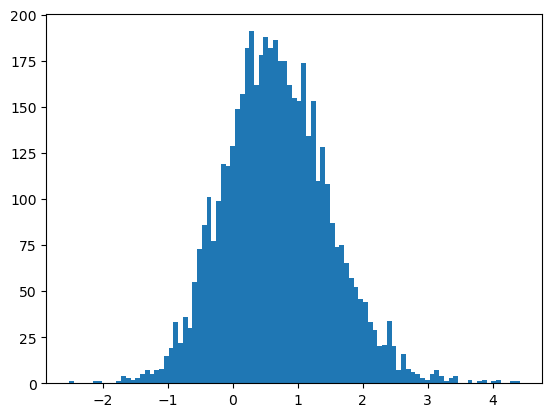

simulation_date = 2024-01-05 00:29:18.070882
mean work = 0.677 ± 0.01150
jarzyn = 0.693 ± 0.00584
[100, 100, 40, 40, 100, 100, 100]
80 40 80 80 60 60


In [62]:
step_time_array = np.cumsum(np.array([x["duration"] for x in protocol_list]))/params['dt']
name_array = [x["name"] for x in protocol_list]

from scipy.stats import sem 

plt.hist(simResult["work_distribution"], bins = 95)
plt.show()
jarzyn_term = np.mean(np.exp(-simResult["work_distribution"]))

avg_W = np.mean(simResult["work_distribution"])
error_W = sem(simResult["work_distribution"])
jarzyn_term_error = np.exp(-avg_W) * error_W

print(f"simulation_date = {simResult['simulation_data']['simulation_date']}")
print(f"mean work = {avg_W:.3f} ± {error_W:.5f}")
print(f'jarzyn = {jarzyn_term:.3f} ± {jarzyn_term_error:.5f}')
print([x["duration"] for x in protocol_list])
print(time_length_1, time_length_2, time_length_3, time_length_4, time_length_5, time_length_6)

## work statistics

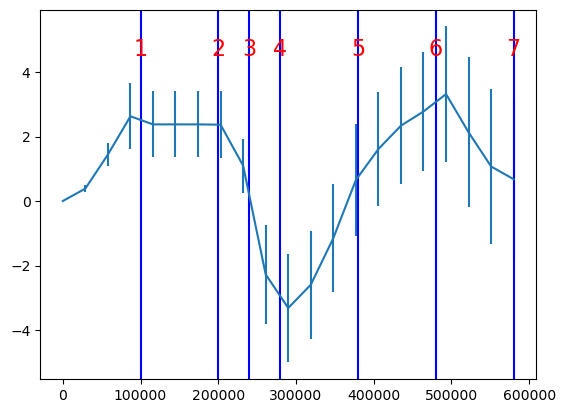

In [63]:
step_array = np.arange(simResult["work_statistic"][:,0].shape[0])
skip_step = int(len(step_array) * 0.05)
work_mean = simResult["work_statistic"][:,0]
work_std = simResult["work_statistic"][:,1]

coarse_step_array = step_array[::skip_step]
coarse_step_array = np.append(coarse_step_array, step_array[-1])
coarse_work_mean_array = work_mean[::skip_step]
coarse_work_mean_array = np.append(coarse_work_mean_array, work_mean[-1])
coarse_work_std_array = np.append(work_std[::skip_step], work_std[-1])

plt.errorbar(coarse_step_array, coarse_work_mean_array, yerr = coarse_work_std_array * 3)

for i, t in enumerate(step_time_array):
    plt.axvline(x = t, color = 'b', label = 'axvline - full height')
    # plt.text('2017-07-02 16:30:00',0.005,'BigNews1',rotation=90,va='top')
    plt.annotate(f"{i+1}", 
            xy=(t, 4.5),  
            # xytext=(quantile_75, 2.05*1e9),
            color='red', 
            ha='center', 
            size=16)

In [20]:
work_mean

array([8.03797379e-06, 1.66681064e-05, 2.58256427e-05, ...,
       7.51340358e-01, 7.51271922e-01, 7.51202927e-01])

In [21]:
WD_at_step_array = np.array([work_mean[i-1] for i in step_time_array.astype(int)])

In [22]:
net_WD = WD_at_step_array[1:] - WD_at_step_array[0:-1]

In [198]:
net_WD

array([-1.83222937, -3.76173547,  4.1483238 ,  1.98399877, -2.18383106])

In [189]:
step_time_array.astype(int)

array([10000, 16000, 20000, 24000, 30000, 40000])

In [182]:
t_array = np.cumsum([p["duration"] for p in protocol_list])

array([100, 160, 200, 240, 300, 400])

# crook analysis

## type 1

In [70]:
counts, bin_edges = np.histogram(simResult["work_distribution"], bins = np.linspace(-2, 2, 50),density=True)
counts, bin_edges = np.histogram(simResult["work_distribution"], bins = np.linspace(-0.2, 0.2, 20),density=True)

In [71]:
log_P_ratio = np.log(counts / counts[::-1])

Text(0, 0.5, 'log ratio')

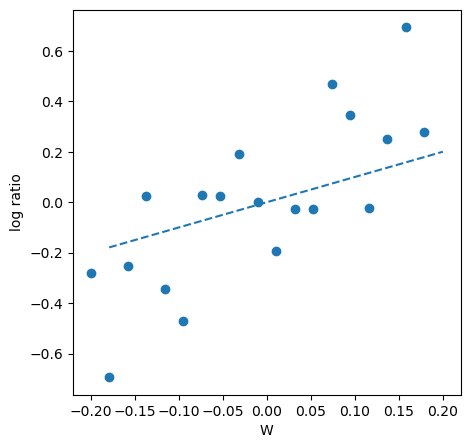

In [72]:
plt.figure(figsize=(5, 5))
plt.plot(bin_edges[1:], bin_edges[1:], "--")
plt.scatter(bin_edges[:-1], log_P_ratio)
plt.xlabel("W")
plt.ylabel("log ratio")

## type 2

dw = 0.001, dt = 0.001, N = 5000
LHS: number of +W, RHS = number of -W * np.exp(+W)]


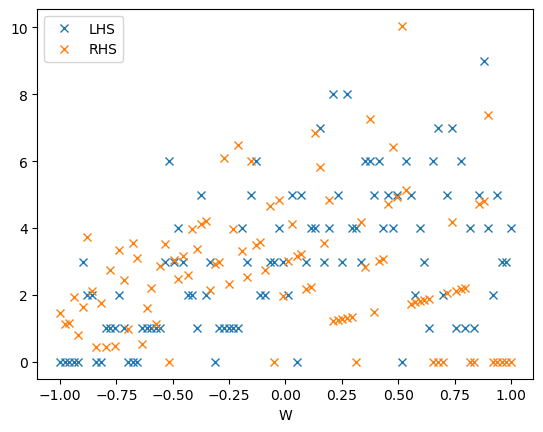

mean work = 0.677 and the std error of W = 0.01150
jarzyn = 0.693, std error= 0.00584
[100, 100, 40, 40, 100, 100, 100]
80 40 80 80 60 60


In [73]:
# crook analysis
# np.linspace(0.005, 0.2, 100)
test_w = np.linspace(-1.0, 1.0, 100)
dw = 0.001
crook_analysis_result = []

for _w in test_w:
    array = simResult["work_distribution"]

    # The 0 index is to remove the single element array
    number_of_plus_W = len(np.where(np.logical_and(array <= _w + dw, array >= _w - dw))[0])
    number_of_minus_W = len(np.where(np.logical_and(array <= -_w + dw, array >= -_w - dw))[0])
    crook_analysis_result.append(np.array([_w, number_of_plus_W, number_of_minus_W * np.exp(_w)]))

crook_analysis_result = np.array(crook_analysis_result)    
print(f"dw = {dw}, dt = {params['dt']}, N = {params['N']}")
print("LHS: number of +W, RHS = number of -W * np.exp(+W)]")
all_w = crook_analysis_result[:, 0]
all_lhs = crook_analysis_result[:, 1]
all_rhs = crook_analysis_result[:, 2]
plt.xlabel("W")
plt.plot(all_w, all_lhs, "x", label = "LHS")
plt.plot(all_w, all_rhs, "x", label = "RHS")
plt.legend()
plt.show()
# print("p(W) = p(-W) exp(W)")
# print(f"LHS = {number_of_plus_W}, RHS = {number_of_minus_W * np.exp(test_w)}")
print(f"mean work = {avg_W:.3f} and the std error of W = {error_W:.5f}")
print(f'jarzyn = {jarzyn_term:.3f}, std error= {jarzyn_term_error:.5f}')
print([x["duration"] for x in protocol_list])
print(time_length_1, time_length_2, time_length_3, time_length_4, time_length_5, time_length_6)

In [47]:
result = {"N": params['N'], "dt": params['dt'], "W_mean": avg_W, "W_std": error_W, 
          "jarzyn": jarzyn_term, "jarzyn_error": jarzyn_term_error}

In [48]:
jarzyn_err_analytic = [ np.exp(-s["W_mean"]) * s["W_std"] for s in data]

NameError: name 'data' is not defined

(array([ 4.,  9., 31., 46., 51., 57., 47., 30., 20.,  7.]),
 array([0.00252326, 0.0025378 , 0.00255233, 0.00256687, 0.0025814 ,
        0.00259594, 0.00261047, 0.00262501, 0.00263954, 0.00265407,
        0.00266861]),
 <BarContainer object of 10 artists>)

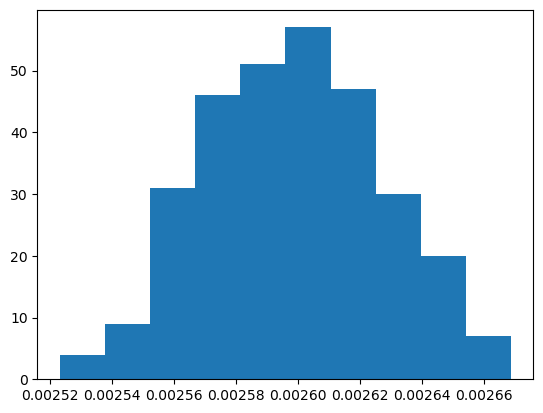

In [14]:
plt.hist(jarzyn_err_analytic)

In [ ]:


# step_array = np.arange(simResult["work_statistic"][:,0].shape[0])
# skip_step = int(len(step_array) * 0.02)
# work_mean = simResult["work_statistic"][:,0]
# work_std = simResult["work_statistic"][:,1]

# coarse_step_array = step_array[::skip_step]
# coarse_step_array = np.append(coarse_step_array, step_array[-1])
# coarse_work_mean_array = work_mean[::skip_step]
# coarse_work_mean_array = np.append(coarse_work_mean_array, work_mean[-1])
# coarse_work_std_array = np.append(work_std[::skip_step], work_std[-1])

# plt.errorbar(coarse_step_array, coarse_work_mean_array, yerr = coarse_work_std_array)

# for i, t in enumerate(step_time_array):
#     plt.axvline(x = t, color = 'b', label = 'axvline - full height')
#     # plt.text('2017-07-02 16:30:00',0.005,'BigNews1',rotation=90,va='top')
#     plt.annotate(f"{i+1}", 
#             xy=(t, 4.5),  
#             # xytext=(quantile_75, 2.05*1e9),
#             color='red', 
#             ha='center', 
#             size=16)

# print(f'jarzyn = {jarzyn_term}')
# print([x["duration"] for x in protocol_list])

# first_half = work_mean[0: len(work_mean)//2]
# second_half = work_mean[len(work_mean)//2:][::-1]
# plt.plot(step_array[0:len(step_array)//2], np.abs(first_half - second_half))

In [ ]:
# print(initial_parameter_dict["phi_1_dcx"], initial_parameter_dict["phi_2_dcx"], initial_parameter_dict["M_12"])
# print(protocol_list)

In [42]:
# animations
vmin, vmax = 0, 100
frame_skip = 10
# phi_1_dc, phi_2_dc = phi_1_dcx, phi_2_dcx
all_state = simResult["cfqr"].sim.output.all_state['states']
simResult["cfqr"].system.protocol_list = protocol_list
time_range = (computation_protocol_parameter_dict["t"][0], computation_protocol_parameter_dict["t"][-1])

ani,_,_ = animate_sim_flux_qubit(all_state, system = simResult["cfqr"].system ,
                                   times = time_range, frame_skip=frame_skip, color_by_state=True,
                                   vmin = vmin, vmax = vmax,
                                   manual_domain = manual_domain)

In [43]:
# from IPython.display import HTML
from IPython import display
video = ani.to_html5_video()
html = display.HTML(video)
display.display(html)

In [ ]:
# import time
# now = str(time.time())
# sim_id = hashlib.sha256(bytes(now, encoding='utf8')).hexdigest()




# # save image and distributions
# np.save(f'cfq_data/tr_analysis/{sim_id}_work_distribution.npy', simResult["work_distribution"])
# plt.hist(simResult["work_distribution"], bins = 45)
# plt.savefig(f'cfq_data/tr_analysis/{sim_id}_work_distribution.png')
# plt.close()

# np.save(f'cfq_data/tr_analysis/{sim_id}_work_statistic.npy', simResult["work_statistic"])
# plt.errorbar(coarse_step_array, coarse_work_mean_array, yerr = coarse_work_std_array)
# plt.plot(step_array[0:len(step_array)//2], np.abs(first_half - second_half))
# plt.savefig(f'cfq_data/tr_analysis/{sim_id}_work_statistic.png')
# plt.close()

# np.save(f"cfq_data/tr_analysis/{sim_id}_state.npy", cfqr.sim.output.all_state["states"])

In [46]:
# get_potential_shot_at_different_t_1D(cfqr, computation_protocol_parameter_dict, manual_domain = manual_domain)

In [20]:
import json
import numpy as np
import matplotlib.pyplot as plt

Z_score = 2
N = 302
with open("cfq_data/variance_analysis_for_TRS_3.json") as f:
    data = json.load(f)
    W_mean_samples = np.array([d["W_mean"] for d in data])
    W_mean_err_samples = np.array([d["W_std"] for d in data])
    jarzyn_samples = np.array([d["jarzyn"] for d in data])
    jarzyn_err_samples = np.array([d["jarzyn_error"] for d in data])
    
    jarzyn_err_expt = np.std(jarzyn_samples)
    jarzyn_err_analytic = np.mean([ np.exp(-s["W_mean"]) * s["W_std"] for s in data])
    print("expt error: ", jarzyn_err_expt)
    print("analytic error: ", jarzyn_err_analytic)


#     data.append(result)
#     with open("cfq_data/variance_analysis_for_TRS_3.json", "w") as f_w:
#         json.dump(data, f_w)

expt error:  0.0028026377563410134
analytic error:  0.002599044763044375


In [23]:
import json
import numpy as np
import matplotlib.pyplot as plt

Z_score = 2
N = 302
with open("cfq_data/variance_analysis_for_TRS_whole_forward.json") as f:
    data = json.load(f)
    print(data)
#     W_mean_samples = np.array([d["W_mean"] for d in data])
#     W_mean_err_samples = np.array([d["W_std"] for d in data])
#     jarzyn_samples = np.array([d["jarzyn"] for d in data])
#     jarzyn_err_samples = np.array([d["jarzyn_error"] for d in data])
    
#     jarzyn_err_expt = np.std(jarzyn_samples)
#     jarzyn_err_analytic = np.mean([ np.exp(-s["W_mean"]) * s["W_std"] for s in data])
#     print("expt error: ", jarzyn_err_expt)
#     print("analytic error: ", jarzyn_err_analytic)


#     data.append(result)
#     with open("cfq_data/variance_analysis_for_TRS_3.json", "w") as f_w:
#         json.dump(data, f_w)

[{'N': 10000, 'dt': 0.01, 'W_mean': -1.395085503630883, 'W_std': 0.0047165293859287695, 'jarzyn': 4.457250222061053, 'jarzyn_error': 0.019032703438973876, 'fidelity': [{'initial': {'location': '00', 'count': 267}, 'final': [{'location': '00', 'count': 175}, {'location': '10', 'count': 89}]}, {'initial': {'location': '01', 'count': 211}, 'final': [{'location': '00', 'count': 132}, {'location': '10', 'count': 77}]}, {'initial': {'location': '10', 'count': 225}, 'final': [{'location': '01', 'count': 67}, {'location': '11', 'count': 157}]}, {'initial': {'location': '11', 'count': 297}, 'final': [{'location': '01', 'count': 85}, {'location': '11', 'count': 207}]}]}, {'N': 10000, 'dt': 0.01, 'W_mean': -1.4001202129991168, 'W_std': 0.004700211510623013, 'jarzyn': 4.474290097389955, 'jarzyn_error': 0.01906258899530266, 'fidelity': [{'initial': {'location': '00', 'count': 298}, 'final': [{'location': '00', 'count': 197}, {'location': '10', 'count': 99}]}, {'initial': {'location': '01', 'count':

In [26]:
f = data[0]["fidelity"]

[{'initial': {'location': '00', 'count': 267},
  'final': [{'location': '00', 'count': 175},
   {'location': '10', 'count': 89}]},
 {'initial': {'location': '01', 'count': 211},
  'final': [{'location': '00', 'count': 132},
   {'location': '10', 'count': 77}]},
 {'initial': {'location': '10', 'count': 225},
  'final': [{'location': '01', 'count': 67},
   {'location': '11', 'count': 157}]},
 {'initial': {'location': '11', 'count': 297},
  'final': [{'location': '01', 'count': 85},
   {'location': '11', 'count': 207}]}]

In [28]:
summaryText = ""
for x in f:
    initialLocation = x["initial"]["location"]
    initialCount = x["initial"]["count"]
    summaryText = f"initial: {initialLocation} ({initialCount}), final: "
    rightLocationCount = sum([y["count"] for y in x["final"]])
    goodRatio = rightLocationCount/initialCount * 100
    for y in x["final"]:
        summaryText += f"{y['location']} ({y['count']}/{rightLocationCount},{y['count']/rightLocationCount * 100: .3g}%),"
    summaryText += f" goodRatio:{goodRatio: .3g}%"
    # print(summaryText)


In [29]:
summaryText

'initial: 11 (297), final: 01 (85/292, 29.1%),11 (207/292, 70.9%), goodRatio: 98.3%'